In [1]:
import pandas as pd
import numpy as np
import optuna
import lightgbm as lgb
import matplotlib.pyplot as plt
import xgboost as xgb
import shap
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingClassifier
from optuna.integration import LightGBMPruningCallback
from optuna.integration import XGBoostPruningCallback
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_predict, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (precision_recall_curve, roc_auc_score, roc_curve,
                             precision_score, recall_score, f1_score, accuracy_score,
                             confusion_matrix, classification_report, average_precision_score)
import warnings

warnings.filterwarnings('ignore')

try:
    # Các tệp này là kết quả từ các bước tiền xử lý trước
    train_df = pd.read_csv(r'C:\Users\DatGo\OneDrive\Documents\Personal_Project\Home_Credit_Default_Risk\application_train_features.csv')
    test_df = pd.read_csv(r'C:\Users\DatGo\OneDrive\Documents\Personal_Project\Home_Credit_Default_Risk\application_test_features.csv')
    print("Tải dữ liệu thành công!")
    print(f"Kích thước tập train: {train_df.shape}")
    print(f"Kích thước tập test: {test_df.shape}")
except FileNotFoundError:
    print("Lỗi: Không tìm thấy tệp cleaned. Vui lòng chạy các bước tiền xử lý và lưu file trước.")
    exit()

Tải dữ liệu thành công!
Kích thước tập train: (307511, 143)
Kích thước tập test: (48744, 142)


In [2]:
# --- Chuẩn bị dữ liệu ---
y = train_df['TARGET']
train_ids = train_df['SK_ID_CURR']
test_ids = test_df['SK_ID_CURR']

X = train_df.drop(['TARGET', 'SK_ID_CURR'], axis=1)
X_test = test_df.drop('SK_ID_CURR', axis=1)

# Mã hóa, căn chỉnh cột
X = pd.get_dummies(X, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)
common_cols = list(set(X.columns) & set(X_test.columns))
X = X[common_cols]
X_test = X_test[common_cols]

# Dọn dẹp infinity và NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
median_values = X.median()
X.fillna(median_values, inplace=True)
X_test.fillna(median_values, inplace=True)

# Tách dữ liệu
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Chuẩn bị dữ liệu hoàn tất.")

Chuẩn bị dữ liệu hoàn tất.


In [3]:
# --- Mô hình A: Logistic Regression ---
print("\n...Huấn luyện mô hình Baseline (Logistic Regression)...")
log_reg = LogisticRegression(C=0.0001, random_state=42, class_weight='balanced')
log_reg.fit(X_train_scaled, y_train)
val_probs_lr = log_reg.predict_proba(X_val_scaled)[:, 1]
auc_lr = roc_auc_score(y_val, val_probs_lr)
print(f"==> Điểm AUC của Logistic Regression: {auc_lr:.5f}")
val_preds_lr_labels = (val_probs_lr >= 0.5).astype(int)
print("--- Báo cáo Phân loại (Classification Report) cho Logistic Regression ---")
print(classification_report(y_val, val_preds_lr_labels, target_names=['Repayer (0)', 'Defaulter (1)']))



...Huấn luyện mô hình Baseline (Logistic Regression)...
==> Điểm AUC của Logistic Regression: 0.75932
--- Báo cáo Phân loại (Classification Report) cho Logistic Regression ---
               precision    recall  f1-score   support

  Repayer (0)       0.96      0.69      0.81     56538
Defaulter (1)       0.17      0.69      0.27      4965

     accuracy                           0.69     61503
    macro avg       0.56      0.69      0.54     61503
 weighted avg       0.90      0.69      0.76     61503



In [4]:
# ---------- Stratified K-Fold ----------
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [5]:
# Chuẩn hóa tên các feature để tránh lỗi JSON của LightGBM
def sanitize_columns(df):
    df = df.copy()
    df.columns = (
        df.columns.str.replace('[^A-Za-z0-9_]', '_', regex=True)
    )
    return df

print("Đang làm sạch tên cột cho X_train và X_val...")
X_train_sanitized = sanitize_columns(X_train)
X_val_sanitized = sanitize_columns(X_val)
print("Làm sạch tên cột hoàn tất.")

Đang làm sạch tên cột cho X_train và X_val...
Làm sạch tên cột hoàn tất.


In [6]:
# --- TÌM KIẾM CÁC THAM SỐ PHÙ HỢP CHO LIGHTGBM ---
def lgb_objective(trial):
    """Hàm mục tiêu để Optuna tối ưu hóa cho LightGBM."""
    
    # Định nghĩa không gian tìm kiếm cho các siêu tham số
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'seed': 42,
        'verbosity': -1,
        'n_estimators': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 5, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 200),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'scale_pos_weight': (y_train == 0).sum() / (y_train == 1).sum()
    }
    
    # Huấn luyện mô hình với dữ liệu đã được làm sạch tên cột
    model = lgb.LGBMClassifier(**params)
    pruning_callback = LightGBMPruningCallback(trial, 'auc')
    
    model.fit(X_train_sanitized, y_train,
              eval_set=[(X_val_sanitized, y_val)],
              eval_metric='auc',
              callbacks=[pruning_callback, lgb.early_stopping(100, verbose=False)])
    
    preds = model.predict_proba(X_val_sanitized)[:, 1]
    auc = roc_auc_score(y_val, preds)
    
    return auc

# Bắt đầu quá trình tối ưu hóa
print("\n--- Bắt đầu Tinh chỉnh Siêu tham số cho LightGBM ---")
lgb_study = optuna.create_study(direction='maximize')
lgb_study.optimize(lgb_objective, n_trials=50) 

# In ra các tham số tốt nhất
print("\n--- Kết quả Tinh chỉnh LightGBM ---")
print('Số thử nghiệm đã hoàn thành:', len(lgb_study.trials))
print('Tham số tốt nhất:', lgb_study.best_params)
print('Điểm AUC tốt nhất:', lgb_study.best_value)

# Lưu các tham số tốt nhất vào một biến
best_lgb_params = lgb_study.best_params

[I 2025-10-07 17:28:18,006] A new study created in memory with name: no-name-e5781751-81ff-4738-a1ad-e69609bfb6e3



--- Bắt đầu Tinh chỉnh Siêu tham số cho LightGBM ---


  File "c:\Users\DatGo\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\DatGo\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\DatGo\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\DatGo\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
[I 2025-10-07 17:28:44,037] Trial 0 finished with value: 0.780178145386947 and parameters: {'learning_rate': 0.061222013582049865, 'num_leaves': 84, 'max_depth': 5, 'min_child_samples'


--- Kết quả Tinh chỉnh LightGBM ---
Số thử nghiệm đã hoàn thành: 50
Tham số tốt nhất: {'learning_rate': 0.02550821786575106, 'num_leaves': 72, 'max_depth': 9, 'min_child_samples': 190, 'subsample': 0.8294159883137522, 'colsample_bytree': 0.918633555182371, 'reg_alpha': 0.17802663117354445, 'reg_lambda': 0.1456884294895714}
Điểm AUC tốt nhất: 0.7808767780776232


In [7]:
# Lấy các tham số tốt nhất từ Optuna và thêm các tham số cố định
lgb_params = best_lgb_params
# Thêm các tham số cố định nếu cần
lgb_params['objective'] = 'binary'
lgb_params['metric'] = 'auc'
lgb_params['boosting_type'] = 'gbdt'
lgb_params['seed'] = 42
lgb_params['verbosity'] = -1
lgb_params.pop('scale_pos_weight', None)
lgb_params.pop('is_unbalance', None)
# Thêm các tham số của Focal Loss
# alpha: Thường được đặt là 0.25, giúp cân bằng giữa lớp âm và dương.
lgb_params['alpha'] = 0.25 

# gamma: Tham số tập trung. Giá trị càng cao, mô hình càng tập trung vào các mẫu khó.
lgb_params['gamma'] = 2.0


In [10]:
def xgb_objective_balanced(trial):
    """Hàm mục tiêu Optuna cho XGBoost sử dụng scale_pos_weight."""
    
    # Tính giá trị scale_pos_weight
    # Tỉ lệ giữa số mẫu của lớp âm (0) và lớp dương (1)
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
    
    params = {
        'objective': 'binary:logistic',  # Sử dụng hàm loss mặc định của XGBoost
        'eval_metric': 'auc',
        'use_label_encoder': False,
        'seed': 42,
        'n_estimators': 2000,
        
        # Thêm scale_pos_weight vào đây để xử lý mất cân bằng
        'scale_pos_weight': scale_pos_weight,
        
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.05),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'subsample': trial.suggest_float('subsample', 0.5, 0.95),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.95),
        'gamma': trial.suggest_float('gamma', 0, 5), # Đây là gamma của cấu trúc cây
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
    }

    # Bây giờ không cần objective tùy chỉnh nữa
    model = xgb.XGBClassifier(**params)
    
    # Callback để cắt tỉa (pruning)
    pruning_callback = XGBoostPruningCallback(trial, 'validation_0-auc')
    
    model.fit(X_train_sanitized, y_train,
              eval_set=[(X_val_sanitized, y_val)],
              early_stopping_rounds=100,
              callbacks=[pruning_callback],
              verbose=False)
    
    preds = model.predict_proba(X_val_sanitized)[:, 1]
    return roc_auc_score(y_val, preds)

# Bắt đầu lại quá trình tối ưu hóa
print("\n--- Bắt đầu Tinh chỉnh Siêu tham số cho XGBoost (dùng scale_pos_weight) ---")
xgb_study_balanced = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(n_warmup_steps=10))

# Chạy optimize với hàm mục tiêu mới đã sửa lỗi
xgb_study_balanced.optimize(xgb_objective_balanced, n_trials=50)

# In ra các tham số tốt nhất
print("\n--- Kết quả Tinh chỉnh XGBoost với scale_pos_weight ---")
print('Số thử nghiệm đã hoàn thành:', len(xgb_study_balanced.trials))
print('Tham số tốt nhất:', xgb_study_balanced.best_params)
print('Điểm AUC tốt nhất:', xgb_study_balanced.best_value)

# Lưu các tham số tốt nhất vào một biến mới (để không ghi đè biến cũ nếu cần)
best_xgb_params_balanced = xgb_study_balanced.best_params

[I 2025-10-07 18:00:14,762] A new study created in memory with name: no-name-d9b6b9f8-e518-44f4-8224-91822f31c442



--- Bắt đầu Tinh chỉnh Siêu tham số cho XGBoost (dùng scale_pos_weight) ---


[I 2025-10-07 18:02:12,673] Trial 0 finished with value: 0.7804865281990738 and parameters: {'learning_rate': 0.038621666349480645, 'max_depth': 6, 'subsample': 0.5629879825027334, 'colsample_bytree': 0.6490099817143788, 'gamma': 3.526081467955625, 'reg_alpha': 3.7698984650570253, 'reg_lambda': 3.335983206138023, 'min_child_weight': 5}. Best is trial 0 with value: 0.7804865281990738.
[I 2025-10-07 18:03:47,742] Trial 1 finished with value: 0.7784644729313763 and parameters: {'learning_rate': 0.035235282037279596, 'max_depth': 7, 'subsample': 0.6099166166820796, 'colsample_bytree': 0.8646276113383775, 'gamma': 1.5317180265999597, 'reg_alpha': 1.4871317493090235, 'reg_lambda': 3.763244293920015, 'min_child_weight': 10}. Best is trial 0 with value: 0.7804865281990738.
[I 2025-10-07 18:05:45,270] Trial 2 finished with value: 0.7779988181446431 and parameters: {'learning_rate': 0.02700865194692302, 'max_depth': 8, 'subsample': 0.7772117869746333, 'colsample_bytree': 0.5527199981903876, 'gam


--- Kết quả Tinh chỉnh XGBoost với scale_pos_weight ---
Số thử nghiệm đã hoàn thành: 50
Tham số tốt nhất: {'learning_rate': 0.038621666349480645, 'max_depth': 6, 'subsample': 0.5629879825027334, 'colsample_bytree': 0.6490099817143788, 'gamma': 3.526081467955625, 'reg_alpha': 3.7698984650570253, 'reg_lambda': 3.335983206138023, 'min_child_weight': 5}
Điểm AUC tốt nhất: 0.7804865281990738


In [ ]:
# Hàm để train LGB theo K-fold và trả về prediction_probs cho validation folds
def lgb_cv_predict_proba(X, y, params, skf, use_smote=False, n_rounds=10000):
    oof_preds = np.zeros(len(y))
    models = []
    for fold, (tr_idx, val_idx) in enumerate(skf.split(X, y)):
        X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
        y_tr, y_val = y[tr_idx], y[val_idx]
        # SMOTE on train only
        if use_smote:
            sm = SMOTE(random_state=42)
            X_tr_res, y_tr_res = sm.fit_resample(X_tr, y_tr)
        else:
            X_tr_res, y_tr_res = X_tr, y_tr

        dtrain = lgb.Dataset(X_tr_res, label=y_tr_res)
        dval = lgb.Dataset(X_val, label=y_val, reference=dtrain)
        model = lgb.train(
            params,
            dtrain,
            num_boost_round=2000,
            valid_sets=[dtrain, dval],
            callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)]
        )
        preds = model.predict(X_val, num_iteration=model.best_iteration)
        oof_preds[val_idx] = preds
        models.append(model)
        print(f"Fold {fold+1} done. Best iter: {model.best_iteration}")
    return oof_preds, models



# Chạy CV 
oof_preds_lgb, lgb_models = lgb_cv_predict_proba(
    X_train_sanitized,
    y_train.reset_index(drop=True).values,
    lgb_params, skf,
    use_smote=True
)

# Metrics trên out-of-fold
print("AUC (oof):", roc_auc_score(y_train, oof_preds_lgb))

Fold 1 done. Best iter: 1110
Fold 2 done. Best iter: 839
Fold 3 done. Best iter: 967
Fold 4 done. Best iter: 1054
Fold 5 done. Best iter: 1260
AUC (oof): 0.7701731381837463
Average precision (PR AUC): 0.2509190328721883


Best threshold (F1): 0.161, precision=0.253, recall=0.432, f1=0.319


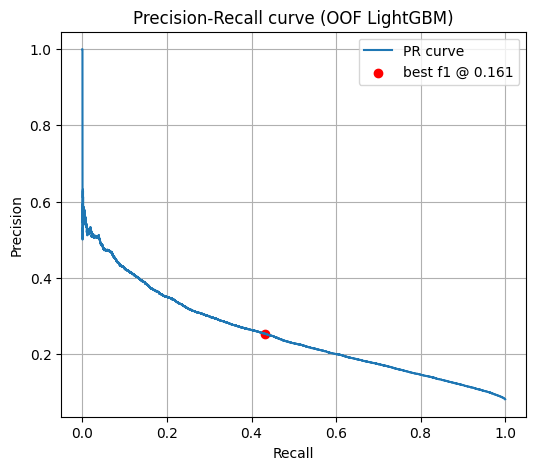


AUC (oof) của LightGBM: 0.7701731381837463
Báo cáo Phân loại (Classification Report) LightGBM:
              precision    recall  f1-score   support

           0     0.9475    0.8901    0.9179     56538
           1     0.2593    0.4379    0.3257      4965

    accuracy                         0.8536     61503
   macro avg     0.6034    0.6640    0.6218     61503
weighted avg     0.8919    0.8536    0.8701     61503



In [12]:
# --- Mô hình B: LightGBM ---
# ------- TÌM THRESHOLD TỐI ƯU  -------------
def find_best_threshold(y_true, probs, metric='f1'):
    precisions, recalls, thresholds = precision_recall_curve(y_true, probs)
    f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-12)
    if metric == 'f1':
        ix = np.nanargmax(f1s)
        return thresholds[ix], precisions[ix], recalls[ix], f1s[ix]
    elif metric == 'balanced_accuracy':
        # Tính toán với nhiều ngưỡng khác nhau bằng cách sử dụng ma trận nhầm lẫn (confusion matrix).
        best = (0.0, 0.0, 0.0, 0.0)
        for t in np.linspace(0.01, 0.99, 99):
            y_pred = (probs >= t).astype(int)
            tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
            recall0 = tn/(tn+fp) if (tn+fp)>0 else 0
            recall1 = tp/(tp+fn) if (tp+fn)>0 else 0
            bal = (recall0 + recall1)/2
            if bal > best[0]:
                best = (bal, t, recall0, recall1)
        return best[1], best[2], best[3], best[0]
    else:
        raise ValueError("metric must be 'f1' or 'balanced_accuracy'")

best_t, best_prec, best_rec, best_f1 = find_best_threshold(y_train.values, oof_preds_lgb, metric='f1')
print(f"Best threshold (F1): {best_t:.3f}, precision={best_prec:.3f}, recall={best_rec:.3f}, f1={best_f1:.3f}")

# Vẽ PR curve & mark threshold
precisions, recalls, thresholds = precision_recall_curve(y_train.values, oof_preds_lgb)
plt.figure(figsize=(6,5))
plt.plot(recalls, precisions, label='PR curve')
plt.scatter([best_rec],[best_prec], color='red', label=f'best f1 @ {best_t:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve (OOF LightGBM)')
plt.legend()
plt.grid(True)
plt.show()

# -------- EVALUATE trên tập val sử dụng best threshold ----------
# Lấy trung bình dự đoán từ tất cả các mô hình LightGBM trên tập X_val.
val_probs = np.mean([m.predict(X_val, num_iteration=m.best_iteration) for m in lgb_models], axis=0)
y_pred_val = (val_probs >= best_t).astype(int)

# In điểm AUC trên tập OOF (Out-of-Fold)
print("\nAUC (oof) của LightGBM:", roc_auc_score(y_train, oof_preds_lgb))

print("Báo cáo Phân loại (Classification Report) LightGBM:")
print(classification_report(y_val, y_pred_val, digits=4))


--- Fold 1 ---
Fold 1 done. Best iter: 99
--- Fold 2 ---
Fold 2 done. Best iter: 99
--- Fold 3 ---
Fold 3 done. Best iter: 99
--- Fold 4 ---
Fold 4 done. Best iter: 99
--- Fold 5 ---
Fold 5 done. Best iter: 99

AUC (oof) của XGBoost: 0.7599751650261881
Best threshold (F1) cho XGBoost: 0.149, precision=0.249, recall=0.411, f1=0.310


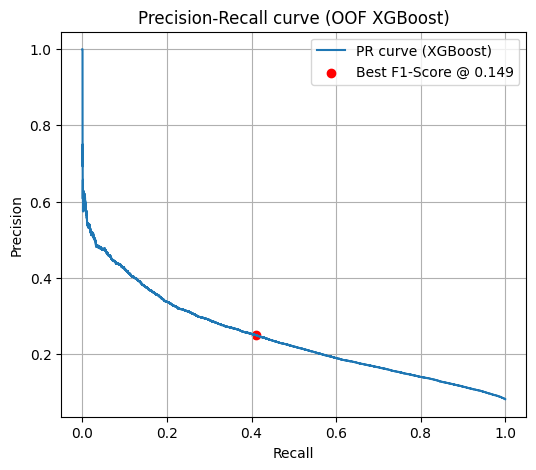


--- Báo cáo Phân loại (Classification Report) XGBoost ---
              precision    recall  f1-score   support

           0     0.9458    0.8939    0.9191     56538
           1     0.2564    0.4167    0.3175      4965

    accuracy                         0.8554     61503
   macro avg     0.6011    0.6553    0.6183     61503
weighted avg     0.8901    0.8554    0.8705     61503



In [13]:
# --- Mô hình C: XGboost ---
def xgb_cv_predict_proba(X, y, params, skf):
    oof_preds = np.zeros(len(y))
    models = []
    
    # Sử dụng X_train_sanitized để đảm bảo tên cột tương thích
    y_values = y.reset_index(drop=True).values

    for fold, (tr_idx, val_idx) in enumerate(skf.split(X_train_sanitized, y_values)):
        print(f"--- Fold {fold+1} ---")
        X_tr, X_val = X_train_sanitized.iloc[tr_idx], X_train_sanitized.iloc[val_idx]
        y_tr, y_val = y_values[tr_idx], y_values[val_idx]
        
        model = xgb.XGBClassifier(**params)
        model.fit(X_tr, y_tr,
                  eval_set=[(X_val, y_val)],
                  early_stopping_rounds=100,
                  verbose=False)
                  
        preds = model.predict_proba(X_val)[:, 1]
        oof_preds[val_idx] = preds
        models.append(model)
        
        # Lấy số vòng lặp tốt nhất từ thuộc tính của mô hình
        best_iter = model.best_iteration if hasattr(model, 'best_iteration') else 'N/A'
        print(f"Fold {fold+1} done. Best iter: {best_iter}")

    return oof_preds, models

# Chạy huấn luyện chéo
oof_preds_xgb, xgb_models = xgb_cv_predict_proba(X_train, y_train, best_xgb_params_balanced, skf)

# In điểm AUC trên tập OOF (Out-of-Fold)
print("\nAUC (oof) của XGBoost:", roc_auc_score(y_train, oof_preds_xgb))


# ---  TÌM NGƯỠNG TỐI ƯU CHO XGBOOST ---
best_t_xgb, best_prec_xgb, best_rec_xgb, best_f1_xgb = find_best_threshold(y_train.values, oof_preds_xgb, metric='f1')
print(f"Best threshold (F1) cho XGBoost: {best_t_xgb:.3f}, precision={best_prec_xgb:.3f}, recall={best_rec_xgb:.3f}, f1={best_f1_xgb:.3f}")

# Vẽ PR curve & mark threshold
precisions_xgb, recalls_xgb, thresholds_xgb = precision_recall_curve(y_train.values, oof_preds_xgb)
plt.figure(figsize=(6,5))
plt.plot(recalls_xgb, precisions_xgb, label='PR curve (XGBoost)')
plt.scatter([best_rec_xgb], [best_prec_xgb], color='red', label=f'Best F1-Score @ {best_t_xgb:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve (OOF XGBoost)')
plt.legend()
plt.grid(True)
plt.show()

# --- ĐÁNH GIÁ TRÊN TẬP VALIDATION ---
# Lấy trung bình dự đoán từ 5 mô hình XGBoost trên tập X_val
val_probs_xgb = np.mean([m.predict_proba(X_val_sanitized)[:, 1] for m in xgb_models], axis=0)

# Áp dụng ngưỡng tối ưu
y_pred_val_xgb = (val_probs_xgb >= best_t_xgb).astype(int)

print("\n--- Báo cáo Phân loại (Classification Report) XGBoost ---")
print(classification_report(y_val, y_pred_val_xgb, digits=4))

In [14]:
# ---------- Mô hình D: STACKING: LightGBM + XGBoost ----------
# Huấn luyện các mô hình cơ sở (base learners) trên toàn bộ tập huấn luyện (hoặc thông qua Cross-Validation), rồi chồng (stack) chúng lại bằng Logistic Regression.
# Chúng ta sẽ xây dựng các lớp bao bọc (wrapper) tương thích với sklearn cho LightGBM và XGBoost.
from sklearn.base import BaseEstimator, ClassifierMixin

class LGBWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, params=None, n_estimators=1000):
        self.params = params or {}
        self.n_estimators = n_estimators
        self.model = None
    def fit(self, X, y):
        dtrain = lgb.Dataset(X, label=y)
        self.model = lgb.train(
            self.params,
            dtrain,
            num_boost_round=self.n_estimators,
            callbacks=[lgb.log_evaluation(0)]
        )
        # Thiết lập thuộc tính classes_ để tương thích với sklearn.
        self.classes_ = np.unique(y)
        return self
    def predict_proba(self, X):
        return np.vstack([1-self.model.predict(X), self.model.predict(X)]).T
    def predict(self, X):
        return (self.model.predict(X) >= 0.5).astype(int)

class XGBWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, params=None, n_estimators=100):
        self.params = params or {}
        self.n_estimators = n_estimators
        self.model = xgb.XGBClassifier(**self.params, n_estimators=self.n_estimators)
    def fit(self, X, y):
        self.model.fit(X, y, verbose=False)
        self.classes_ = np.unique(y)
        return self
    def predict_proba(self, X):
        return self.model.predict_proba(X)
    def predict(self, X):
        return self.model.predict(X)

lgb_wrapper = LGBWrapper(params=lgb_params, n_estimators=500)
xgb_wrapper = XGBWrapper(params=best_xgb_params_balanced, n_estimators=500)

estimators = [
    ('lgb', lgb_wrapper),
    ('xgb', xgb_wrapper)
]

stack_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=1000),
    cv=skf,
    n_jobs=-1,
    passthrough=False
)

# Tùy chọn thêm bước chuẩn hóa (scaling) hoặc SMOTE vào pipeline cho mô hình stacker.
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('stack', stack_clf)
])

# Huấn luyện mô hình stacking trên toàn bộ tập dữ liệu huấn luyện
pipe.fit(X_train_sanitized, y_train)
X_test_sanitized = sanitize_columns(X_test)
# Dự đoán trên tập dữ liệu kiểm thử (test set)
stack_probs = pipe.predict_proba(X_test_sanitized)[:,1]
# Tìm ngưỡng dự đoán tối ưu trên tập validation (trước đó ta dùng OOF; nhưng ta cũng có thể tính ngưỡng trên OOF của train bằng cross_val_predict)
oof_stack = cross_val_predict(pipe, X_train_sanitized, y_train, cv=skf, method='predict_proba', n_jobs=-1)[:,1]
best_t_stack, bp, br, bf = find_best_threshold(y_train.values, oof_stack, metric='f1')
print("Stack best threshold (F1):", best_t_stack, "f1:", bf)
val_stack_probs = pipe.predict_proba(X_val_sanitized)[:,1]
y_pred_stack_val = (val_stack_probs >= best_t_stack).astype(int)

# In báo cáo cho tập validation
print("Báo cáo Phân loại (Classification Report) Stacking:")
print(classification_report(y_val, y_pred_stack_val, digits=4))
print("Stack ROC AUC (validation):", roc_auc_score(y_val, val_stack_probs))

# ---------- Độ ổn định của Cross-Validation ----------
# Hiển thị độ biến động của các chỉ số đánh giá giữa các fold cho LightGBM
fold_f1s = []
for tr_idx, val_idx in skf.split(X_train, y_train):
    y_true = y_train.iloc[val_idx].values
    yprob = oof_preds_lgb[val_idx]
    _, _, _, f1_val = find_best_threshold(y_true, yprob, metric='f1')
    fold_f1s.append(f1_val)
print("LGB fold F1s:", fold_f1s)
print("mean f1:", np.mean(fold_f1s), "std:", np.std(fold_f1s))

Stack best threshold (F1): 0.1162748538081073 f1: 0.32727342168535584
Báo cáo Phân loại (Classification Report) Stacking:
              precision    recall  f1-score   support

           0     0.9481    0.8955    0.9210     56538
           1     0.2706    0.4415    0.3355      4965

    accuracy                         0.8588     61503
   macro avg     0.6093    0.6685    0.6283     61503
weighted avg     0.8934    0.8588    0.8738     61503

Stack ROC AUC (validation): 0.7817826273176091
LGB fold F1s: [0.3155266208860135, 0.3234901886068834, 0.3232682060386198, 0.32308462693993145, 0.31635025183989857]
mean f1: 0.3203439788622694 std: 0.003608813811274113


In [15]:
# --- HIỆU CHỈNH XÁC SUẤT CHO MÔ HÌNH LIGHTGBM ---
print("--- Bắt đầu Hiệu chỉnh Xác suất cho LightGBM ---")

# Huấn luyện một mô hình LightGBM duy nhất trên toàn bộ tập train
print("Huấn luyện một mô hình LightGBM duy nhất trên toàn bộ tập train...")
# Sử dụng lgb_params đã được tối ưu và có Focal Loss
single_lgb_model = lgb.LGBMClassifier(**lgb_params, n_estimators=2000)

# Dùng early stopping để tìm số cây tối ưu trên toàn bộ tập train
single_lgb_model.fit(X_train_sanitized, y_train,
                     eval_set=[(X_val_sanitized, y_val)],
                     eval_metric='auc',
                     callbacks=[lgb.early_stopping(100, verbose=False)])


# Huấn luyện bộ hiệu chỉnh
print("\nHuấn luyện bộ hiệu chỉnh...")
calibrated_lgb = CalibratedClassifierCV(single_lgb_model, method='isotonic', cv='prefit')
calibrated_lgb.fit(X_val_sanitized, y_val)


# Đánh giá lại hiệu suất với xác suất đã hiệu chỉnh
print("\nĐánh giá và so sánh...")
calibrated_lgb_probs = calibrated_lgb.predict_proba(X_val_sanitized)[:, 1]

# Tìm ngưỡng tối ưu mới
best_t_lgb_calibrated, _, _, best_f1_lgb_calibrated = find_best_threshold(y_val.values, calibrated_lgb_probs, metric='f1')
print(f"\nNgưỡng tối ưu mới cho LGBM (sau khi hiệu chỉnh): {best_t_lgb_calibrated:.3f}, F1-Score: {best_f1_lgb_calibrated:.4f}")

# Áp dụng ngưỡng mới
y_pred_val_lgb_calibrated = (calibrated_lgb_probs >= best_t_lgb_calibrated).astype(int)

print("\n--- Báo cáo Phân loại MỚI cho LGBM (Calibrated) ---")
print(classification_report(y_val, y_pred_val_lgb_calibrated, digits=4))

--- Bắt đầu Hiệu chỉnh Xác suất cho LightGBM ---
Huấn luyện một mô hình LightGBM duy nhất trên toàn bộ tập train...

Huấn luyện bộ hiệu chỉnh...

Đánh giá và so sánh...

Ngưỡng tối ưu mới cho LGBM (sau khi hiệu chỉnh): 0.171, F1-Score: 0.3341

--- Báo cáo Phân loại MỚI cho LGBM (Calibrated) ---
              precision    recall  f1-score   support

           0     0.9456    0.9111    0.9280     56538
           1     0.2850    0.4036    0.3341      4965

    accuracy                         0.8701     61503
   macro avg     0.6153    0.6574    0.6311     61503
weighted avg     0.8923    0.8701    0.8801     61503



In [16]:
# --- HIỆU CHỈNH XÁC SUẤT CHO Stacking ---

# pipe: là mô hình Stacking đã được huấn luyện trên X_train
# cv='prefit': báo cho CalibratedClassifierCV biết rằng pipe đã được huấn luyện rồi, không cần huấn luyện lại.
# method='isotonic': là phương pháp hiệu chỉnh mạnh mẽ, phi tham số.
calibrated_clf = CalibratedClassifierCV(pipe, method='isotonic', cv='prefit')

# Huấn luyện bộ hiệu chỉnh trên tập validation
calibrated_clf.fit(X_val_sanitized, y_val)

# --- ĐÁNH GIÁ LẠI HIỆU SUẤT VỚI XÁC SUẤT ĐÃ HIỆU CHỈNH ---
# Lấy xác suất đã được hiệu chỉnh trên tập validation
calibrated_val_probs = calibrated_clf.predict_proba(X_val_sanitized)[:, 1]

# Tìm ngưỡng tối ưu MỚI trên các xác suất đã được hiệu chỉnh
best_t_calibrated, _, _, best_f1_calibrated = find_best_threshold(y_val.values, calibrated_val_probs, metric='f1')

print(f"\nNgưỡng tối ưu mới (sau khi hiệu chỉnh): {best_t_calibrated:.3f}, F1-Score: {best_f1_calibrated:.4f}")

# Áp dụng ngưỡng mới
y_pred_val_calibrated = (calibrated_val_probs >= best_t_calibrated).astype(int)

print("\n--- Báo cáo Phân loại (Classification Report) Stacking (Calibrated) ---")
print(classification_report(y_val, y_pred_val_calibrated, digits=4))


Ngưỡng tối ưu mới (sau khi hiệu chỉnh): 0.179, F1-Score: 0.3384

--- Báo cáo Phân loại (Classification Report) Stacking (Calibrated) ---
              precision    recall  f1-score   support

           0     0.9507    0.8807    0.9144     56538
           1     0.2612    0.4804    0.3384      4965

    accuracy                         0.8483     61503
   macro avg     0.6060    0.6805    0.6264     61503
weighted avg     0.8951    0.8483    0.8679     61503



Đang tạo dữ liệu nền cho SHAP explainer...
Đang khởi tạo SHAP KernelExplainer...
Đang tính toán giá trị SHAP trên tập validation... (Vui lòng chờ)


  0%|          | 0/100 [00:00<?, ?it/s]

Đang tạo biểu đồ SHAP summary plot...
SHAP values shape: (100, 238, 2)
X_val_sample shape: (100, 238)


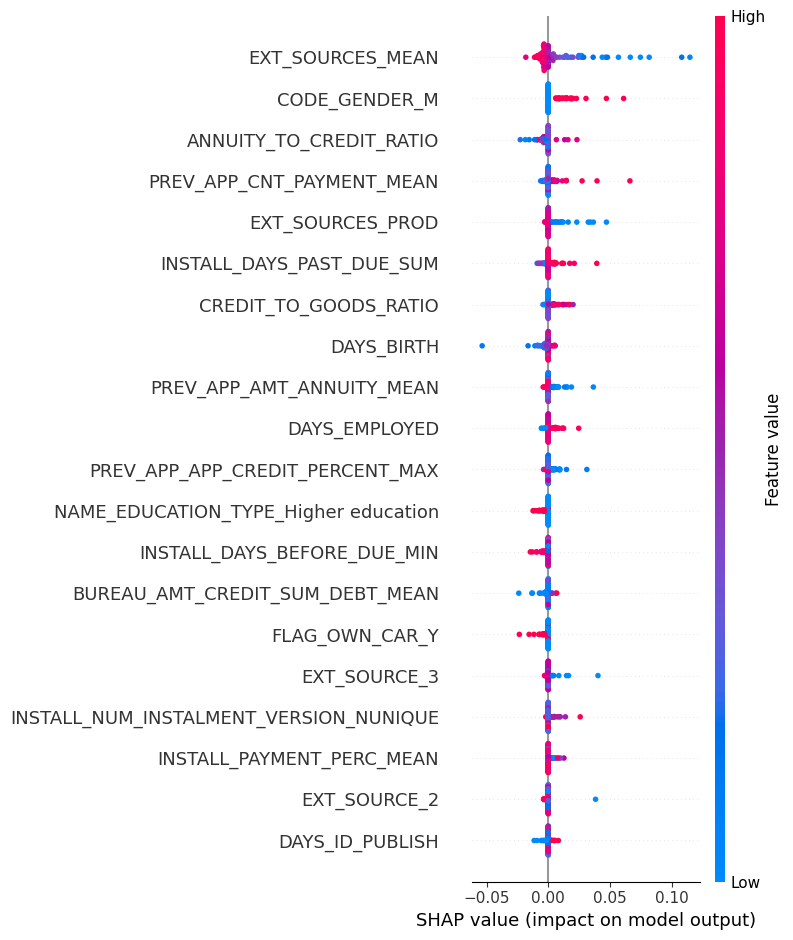

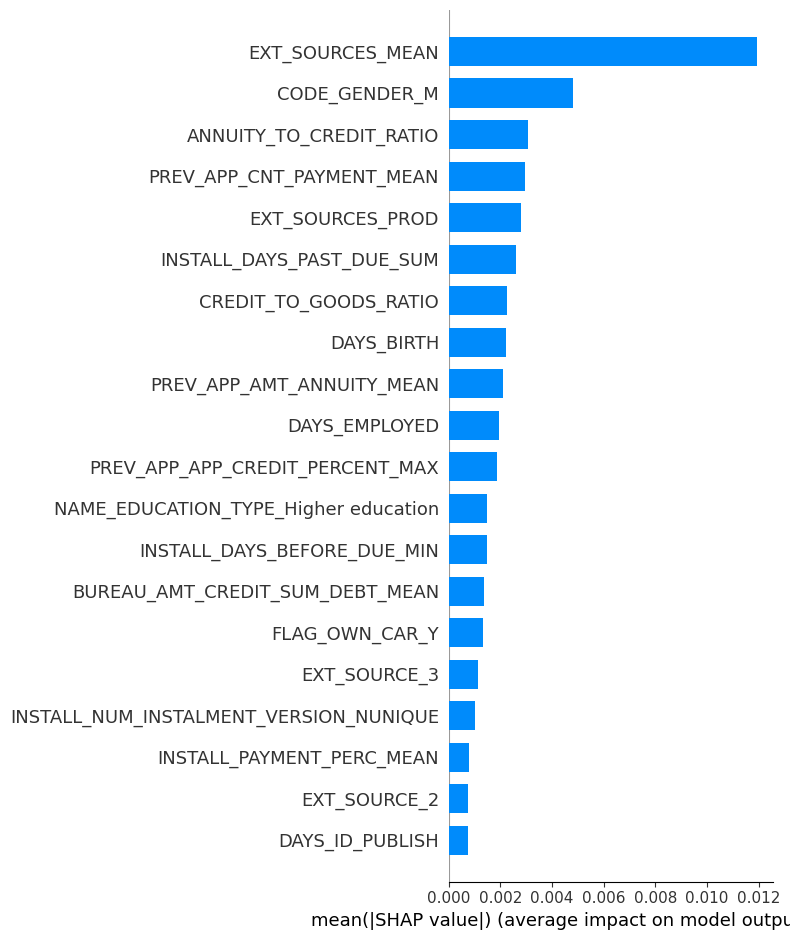

In [17]:
# KernelExplainer cần một tập dữ liệu nền để tính toán giá trị kỳ vọng của mô hình.
# Ta dùng thuật toán K-Means để tóm tắt tập X_train thành 50 điểm dữ liệu đại diện.
print("Đang tạo dữ liệu nền cho SHAP explainer...")
background_data = shap.kmeans(X_train, 50)

# Tạo hàm wrapper để tránh lỗi với feature names
def model_predict(X):
	"""Wrapper function for pipeline prediction"""
	if hasattr(X, 'values'):
		X = X.values
	return pipe.predict_proba(X)

print("Đang khởi tạo SHAP KernelExplainer...")
explainer = shap.KernelExplainer(model_predict, background_data)

# Ta sẽ tính toán giá trị SHAP trên một mẫu nhỏ của tập validation để tiết kiệm thời gian.
print("Đang tính toán giá trị SHAP trên tập validation... (Vui lòng chờ)")
X_val_sample = X_val.sample(n=100, random_state=42)
shap_values = explainer.shap_values(X_val_sample)


# Ta vẽ summary_plot cho lớp 1 (khả năng vỡ nợ).
print("Đang tạo biểu đồ SHAP summary plot...")

# Kiểm tra shape và trích xuất đúng giá trị SHAP cho lớp 1
print(f"SHAP values shape: {shap_values.shape}")
print(f"X_val_sample shape: {X_val_sample.shape}")

# Với bài toán phân loại nhị phân, shap_values nên có dạng 2 chiều: [n_samples, n_features]
# Nếu có dạng 3 chiều: [n_samples, n_features, n_classes], ta cần trích xuất lớp 1
if len(shap_values.shape) == 3:
	shap_values_class1 = shap_values[:, :, 1]  # Extract class 1 (default risk)
else:
	shap_values_class1 = shap_values

plt.figure(figsize=(12, 8))
plt.title("SHAP Summary Plot - Stacking Model (Class 1: Default Risk)")
shap.summary_plot(shap_values_class1, X_val_sample, show=False, plot_type="dot")
plt.tight_layout()
plt.show()

# Tạo thêm biểu đồ feature importance
plt.figure(figsize=(10, 8))
plt.title("SHAP Feature Importance - Stacking Model")
shap.summary_plot(shap_values_class1, X_val_sample, plot_type="bar", show=False)
plt.tight_layout()
plt.show()

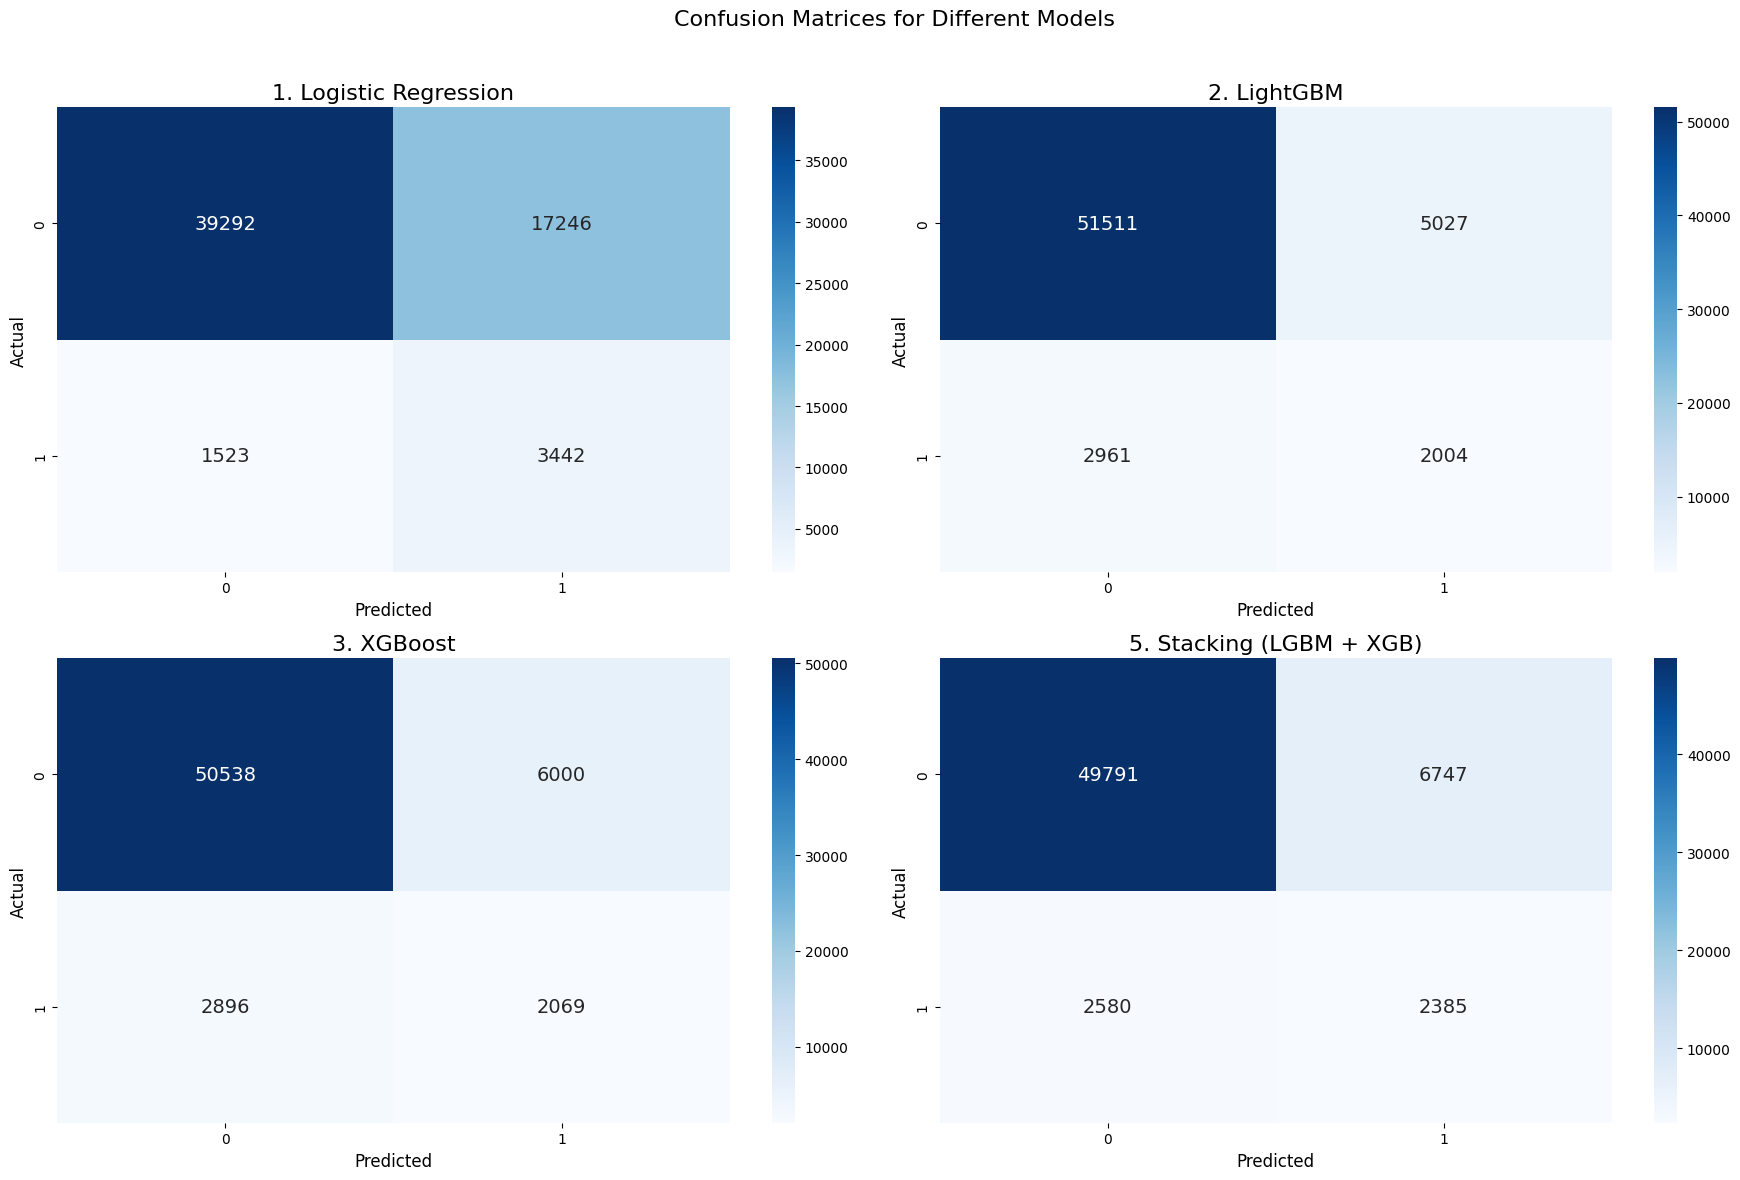

Bảng So Sánh Hiệu Suất Các Mô Hình:
                 Model  Accuracy  Precision (Class 1)  Recall (Class 1)  \
0  Logistic Regression    0.6948               0.1664            0.6933   
1             LightGBM    0.8701               0.2850            0.4036   
2              XGBoost    0.8554               0.2564            0.4167   
3             Stacking    0.8483               0.2612            0.4804   

   F1-Score (Class 1)  ROC AUC  
0              0.2684   0.7593  
1              0.3341   0.7809  
2              0.3175   0.7656  
3              0.3384   0.7829  


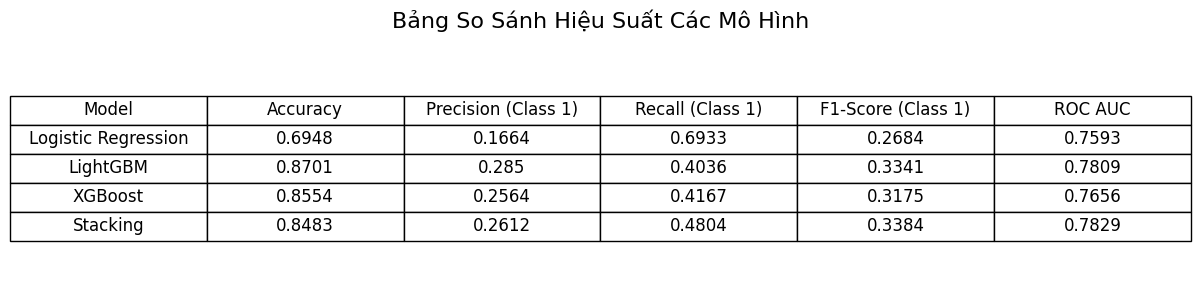

In [18]:
# Tạo ma trận nhầm lẫn cho tất cả các mô hình đã huấn luyện
# Tạo subplot cho các ma trận nhầm lẫn
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Confusion Matrices for Different Models', fontsize=16)

# 1. Logistic Regression
cm_lr = confusion_matrix(y_val, val_preds_lr_labels)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0], annot_kws={"size": 14})
axes[0, 0].set_title('1. Logistic Regression', fontsize=16)
axes[0, 0].set_xlabel('Predicted', fontsize=12)
axes[0, 0].set_ylabel('Actual', fontsize=12)

# 2. LightGBM
cm_lgb = confusion_matrix(y_val, y_pred_val_lgb_calibrated)
sns.heatmap(cm_lgb, annot=True, fmt='d', cmap='Blues', ax=axes[0, 1], annot_kws={"size": 14})
axes[0, 1].set_title('2. LightGBM', fontsize=16)
axes[0, 1].set_xlabel('Predicted', fontsize=12)
axes[0, 1].set_ylabel('Actual', fontsize=12)

# 3. XGBoost
cm_xgb = confusion_matrix(y_val, y_pred_val_xgb)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0], annot_kws={"size": 14})
axes[1, 0].set_title('3. XGBoost', fontsize=16)
axes[1, 0].set_xlabel('Predicted', fontsize=12)
axes[1, 0].set_ylabel('Actual', fontsize=12)

# 4. Stacking Model Calibrated
cm_stack = confusion_matrix(y_val, y_pred_val_calibrated)
sns.heatmap(cm_stack, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1], annot_kws={"size": 14})
axes[1, 1].set_title('5. Stacking (LGBM + XGB)', fontsize=16)
axes[1, 1].set_xlabel('Predicted', fontsize=12)
axes[1, 1].set_ylabel('Actual', fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# 5. So sánh metrics
# Tính toán các metrics cho từng mô hình
models_metrics = {
    'Model': ['Logistic Regression', 'LightGBM', 'XGBoost', 'Stacking'],
    'Accuracy': [
        accuracy_score(y_val, val_preds_lr_labels),
        accuracy_score(y_val, y_pred_val_lgb_calibrated),
        accuracy_score(y_val, y_pred_val_xgb), 
        accuracy_score(y_val, y_pred_val_calibrated)
    ],
    'Precision (Class 1)': [
        precision_score(y_val, val_preds_lr_labels),
        precision_score(y_val, y_pred_val_lgb_calibrated),
        precision_score(y_val, y_pred_val_xgb), 
        precision_score(y_val, y_pred_val_calibrated)
    ],
    'Recall (Class 1)': [
        recall_score(y_val, val_preds_lr_labels),
        recall_score(y_val, y_pred_val_lgb_calibrated),
        recall_score(y_val, y_pred_val_xgb),
        recall_score(y_val, y_pred_val_calibrated)
    ],
    'F1-Score (Class 1)': [
        f1_score(y_val, val_preds_lr_labels),
        f1_score(y_val, y_pred_val_lgb_calibrated),
        f1_score(y_val, y_pred_val_xgb),
        f1_score(y_val, y_pred_val_calibrated)
    ],
    'ROC AUC': [
        roc_auc_score(y_val, val_probs_lr),
        roc_auc_score(y_val, calibrated_lgb_probs),
        roc_auc_score(y_val, val_probs_xgb),
        roc_auc_score(y_val, calibrated_val_probs)
    ]
}

metrics_df = pd.DataFrame(models_metrics)
print("Bảng So Sánh Hiệu Suất Các Mô Hình:")
print(metrics_df.round(4))

# Tạo bảng so sánh trên một biểu đồ riêng
fig, ax = plt.subplots(figsize=(12, 3)) # Tạo một figure mới chỉ để chứa bảng
ax.set_title('Bảng So Sánh Hiệu Suất Các Mô Hình', fontsize=16, pad=20)
ax.axis('off')
table = ax.table(cellText=metrics_df.round(4).values,
                 colLabels=metrics_df.columns,
                 cellLoc='center',
                 loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.8) # Điều chỉnh kích thước bảng

plt.tight_layout()
plt.show()


In [19]:
# ---------- Tạo tệp submission với mô hình đã được tối ưu hóa ----------
final_model = 'calibrated_stacking_model.joblib'
print(f"Đang lưu mô hình vào tệp '{final_model}'...")
joblib.dump(calibrated_clf, final_model)
test_predictions = calibrated_clf.predict_proba(X_test_sanitized)[:, 1]
submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
submission.to_csv('submission_tuned.csv', index=False)
print("\nĐã tạo tệp 'submission_tuned.csv' với mô hình đã được tối ưu hóa!\n")

Đang lưu mô hình vào tệp 'calibrated_stacking_model.joblib'...

Đã tạo tệp 'submission_tuned.csv' với mô hình đã được tối ưu hóa!

